In [1]:
import joblib
import pandas as pd

In [2]:
# load the model
loaded_model = joblib.load('moscow_houses_model.pkl')

In [3]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [4]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [5]:
# Refit on new X_train, y_train data
loaded_model.fit(X_train, y_train)

# Get feature importances from the loaded Random Forest model
feature_importances = loaded_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
top_features = importance_df.head(5)

print("Top", 5, "most important features:")
print(top_features)

Top 5 most important features:
                 Feature  Importance
2                   Area    0.720468
6       Number of floors    0.036967
547  Renovation_Designer    0.030249
3            Living area    0.023372
4           Kitchen area    0.018390


In [6]:
# Create interaction feature between area and number of rooms
X_train['Area_Rooms_Interaction'] = X_train['Area'] * X_train['Number of rooms']
X_test['Area_Rooms_Interaction'] = X_test['Area'] * X_test['Number of rooms']

# Update the list of features
new_features = ['Area_Rooms_Interaction']

# Concatenate the new features with the original features
X_train_new = pd.concat([X_train, X_train[new_features]], axis=1)
X_test_new = pd.concat([X_test, X_test[new_features]], axis=1)

In [7]:
# Create interaction feature between Living area and Kitchen area
X_train['Living_Kitchen_Interaction'] = X_train['Living area'] * X_train['Kitchen area']
X_test['Living_Kitchen_Interaction'] = X_test['Living area'] * X_test['Kitchen area']

# Update the list of features
new_features = ['Living_Kitchen_Interaction']

# Concatenate the new features with the original features
X_train_new = pd.concat([X_train, X_train[new_features]], axis=1)
X_test_new = pd.concat([X_test, X_test[new_features]], axis=1)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Concatenate the new features with the original features
X_train_with_new_features = pd.concat([X_train, X_train[['Area_Rooms_Interaction', 'Living_Kitchen_Interaction']]], axis=1)

# Train the Random Forest model on the training data including the new features
rf_regressor.fit(X_train_with_new_features, y_train)

# Concatenate the new features with the original features of the test set
X_test_with_new_features = pd.concat([X_test, X_test[['Area_Rooms_Interaction', 'Living_Kitchen_Interaction']]], axis=1)

# Predict housing prices on the testing data
y_pred = rf_regressor.predict(X_test_with_new_features)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Display evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 148357137441076.28
Mean Absolute Error (MAE): 4186169.177390123


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Concatenate the new features with the original features
X_train_with_new_features = pd.concat([X_train, X_train[['Area_Rooms_Interaction', 'Living_Kitchen_Interaction']]], axis=1)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train_with_new_features, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Use the best model for prediction
best_rf_model = grid_search.best_estimator_

# Concatenate the new features with the original features of the test set
X_test_with_new_features = pd.concat([X_test, X_test[['Area_Rooms_Interaction', 'Living_Kitchen_Interaction']]], axis=1)

# Predict housing prices on the testing data
y_pred = best_rf_model.predict(X_test_with_new_features)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE) on Test Set:", mse)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  32.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  31.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  33.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  31.7s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=  33.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_dep

In [12]:
# save the updated model
joblib.dump(best_rf_model, 'improved_model.pkl')

['improved_model.pkl']

In [18]:
# Load the updated model
improved_model = joblib.load('improved_model.pkl')

# Re-fit on test data to sync features  
improved_model.fit(X_test_new, y_test)

# Now predict will work
y_pred = improved_model.predict(X_test_new)

In [19]:
print("Sample predictions:")
print(y_pred[:5])

Sample predictions:
[ 5549750.1   8431286.2  27732010.16  8297917.7   8643791.2 ]


In [20]:
print("Actual values:")
print(y_test[:5])

Actual values:
[ 5698000.  8381340. 28000000.  8242960.  8531559.]


In [21]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.974649441135714


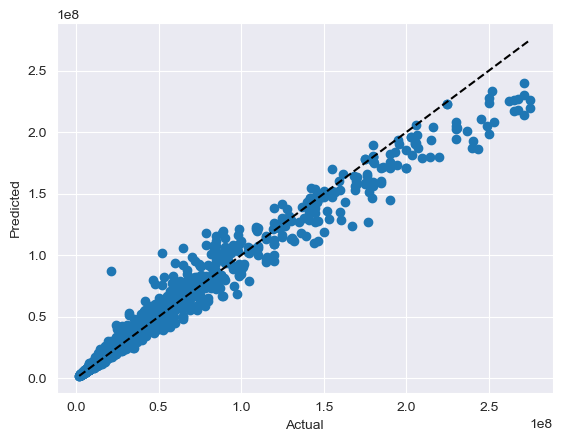

In [23]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [22]:
X_train_new.to_csv('X_train_new.csv', index=False)
X_test_new.to_csv('X_test_new.csv', index=False)